In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [2]:
!mkdir ./data
!wget https://raw.githubusercontent.com/dmasny99/techpark2021/main/hometasks/hometask%203/Test.csv -O ./data/Test.csv
!wget https://raw.githubusercontent.com/dmasny99/techpark2021/main/hometasks/hometask%203/Train.csv -O ./data/Train.csv
!pip install catboost

--2021-04-27 06:41:37--  https://raw.githubusercontent.com/dmasny99/techpark2021/main/hometasks/hometask%203/Test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6608738 (6.3M) [text/plain]
Saving to: ‘./data/Test.csv’

./data/Test.csv     100%[===================>]   6.30M  --.-KB/s    in 0.1s    

2021-04-27 06:41:38 (48.2 MB/s) - ‘./data/Test.csv’ saved [6608738/6608738]

--2021-04-27 06:41:38--  https://raw.githubusercontent.com/dmasny99/techpark2021/main/hometasks/hometask%203/Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 20

In [41]:
data_train = pd.read_csv('./data/Train.csv')
data_test = pd.read_csv('./data/Test.csv')

In [42]:
# разбиваю данные на признаки и таргет
# удаляю из трейна и теста id 
y_train = pd.DataFrame(data_train.price, columns=['price'])
X_train = data_train.drop(['id','price'],axis=1)
X_test = data_test.drop('id',axis=1)


In [43]:
# кастомный класс для обработки даты
# дату заменяю только на месяц
from sklearn.base import BaseEstimator, TransformerMixin
class DateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
    # заменяю дату на месяц
        for i in range(X.shape[0]):
          X.date[i] = int(X.date[i][-1])
        return X

In [44]:
# нахожу ближайший ответ из массива уникальных значения для каждой фичи
# переопределяю сырое значение после импутера на ближайшее к нему
def dist(data, labels,idx):
  for i in idx:
    distance = []
    for j in range(len(labels)):
      distance.append(abs(data[i]-labels[j]))
    min_dist = min(distance)
    min_idx = distance.index(min_dist)
    data[i] = labels[min_idx]


In [46]:
# кастомный класс для заполнения NaN через KNNimputation 
# ничего толкового из этого не вышло
from sklearn.impute import KNNImputer
class NaNImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        idx = np.array(X.index[X.isnull().any(axis=1)].tolist()) # индексы строк, в которых есть наны, чтобы прогонять цикл только по ним
        g_lift_unique = X.g_lift.unique()  # убираю наны из списка уникальных значений
        g_lift_unique = g_lift_unique[~np.isnan(g_lift_unique)]
        build_tech_unique = X.build_tech.unique()
        build_tech_unique = build_tech_unique[~np.isnan(build_tech_unique)]
        metro_dist_unique = X.metro_dist.unique()
        metro_dist_unique = metro_dist_unique[~np.isnan(metro_dist_unique)]
        imputer = KNNImputer(n_neighbors=3, weights='uniform', metric='nan_euclidean') # число соседей подобрал эмпирически
        filled_data = imputer.fit_transform(X.values)
        # работает импутер не до конца корректно и на бинарных признаках может давать промежуточные значения
        # подчищаю за импутером
        filled_df = pd.DataFrame(filled_data,columns=X.columns)
        dist(filled_df.g_lift,g_lift_unique,idx)
        dist(filled_df.build_tech,build_tech_unique,idx)
        dist(filled_df.metro_dist,metro_dist_unique,idx)
        return filled_df


In [47]:
class CatFeaturesToInt(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["date"] = X["date"].astype(np.int) 
        X["build_tech"] = X["build_tech"].astype(np.int) 
        X["street_id"] = X["street_id"].astype(np.int) 
        return X

In [48]:

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('transform_date', DateTransformer()),
    ('imputer',NaNImputer()),
    ('cat_feat_prepr',CatFeaturesToInt())
])
X_train_prepared = pipeline.fit_transform(X_train)
X_test_prepared = pipeline.fit_transform(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [52]:
from catboost import CatBoostRegressor
cat_feat=["date","build_tech","street_id"]
model = CatBoostRegressor(loss_function='MAE',cat_features=cat_feat,early_stopping_rounds=22,eval_metric = 'MAE') # 22 выбрал рандомно
# как я понял из доки, кросс вал тут встроена в гридсерч
# беру 5 фолдов и размер трейна 0.8

grid = {'learning_rate': [0.1,0.5,1],
        'depth': [8,10,12],
        'iterations': [250,500,1000]}
grid_search_result = model.grid_search(grid, 
                                       X=X_train_prepared, 
                                       y=y_train,
                                       verbose = False,
                                       partition_random_seed = 123,
                                       cv = 5,
                                       train_size=0.8,
                                       plot=False)
grid_search_result


Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 1100486.8089838	test: 1052807.6406239	best: 1052807.6406239 (4)	total: 482ms	remaining: 1m 36s
5:	learn: 1039334.9111463	test: 984801.9701614	best: 984801.9701614 (5)	total: 586ms	remaining: 1m 37s
6:	learn: 1007459.9528650	test: 947826.5821614	best: 947826.5821614 (6)	total: 693ms	remaining: 1m 38s
7:	learn: 984700.2578193	test: 924845.5348896	best: 924845.5348896 (7)	total: 769ms	remaining: 1m 35s
8:	learn: 970851.3825451	test: 906771.9070841	best: 906771.9070841 (8)	total: 846ms	remaining: 1m 33s
9:	learn: 950211.4893198	test: 885204.5506490	best: 885204.5506490 (9)	total: 959ms	remaining: 1m 34s
10:	learn: 937116.8189883	test: 873175.0162148	best: 873175.0162148 (10)	total: 1.06s	remaining: 1m 35s
11:	learn: 911255.1108127	test: 851107.3218330	best: 851107.3218330 (11)	total: 1.14s	remaining: 1m 34s
12:	learn: 899926.9192402	test: 839371.4079078	best: 839371.4079078 (12)	total: 1.25s	remaining: 1m 34s
13:

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

In [53]:
model.best_score_

{'learn': {'MAE': 576224.1482071866}}

In [55]:
# после гридсерча модель уже обучена на наилучших параметрах, поэтому сразу предикчу
pred_on_train = model.predict(X_train_prepared)

Text(0, 0.5, 'Предсказанные цены')

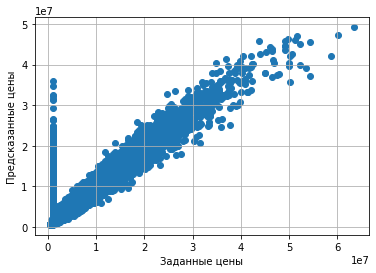

In [63]:
fig, ax = plt.subplots()

ax.scatter(y_train,pred_on_train)
ax.grid()
plt.xlabel("Заданные цены")
plt.ylabel("Предсказанные цены")

Из графика видно, что модель завышает цены для некоторых квартир. Это может быть связано с тем, что присутствует слишком дорогое жилье, при этом оно по определенным фичам не отличается от дешевого (т.е. я имею в виду элитное жилье (например однокомнатная квартира в центре дороже чем трехкомнатная на окраинее - примерно такая аналогия). Чтобы это пофиксить и снизить MAE нужно выкиинуть эти значения. К сожалению, реализовать это я не успеваю, поэтому оставлю тут идеи. Можно сгруппировать квартиры по id_street чтобы определить улицу на которой строится самое дорогое жилье, далее можно посмотреть на среднюю стоимость за квадратный метр и отбросить квартиры, стоимость которых за квадратный метр превышает определенный порог. Определенный порог мы должны найти и задать сами. Я думаю, это должно сработать хорошо.

In [61]:
# предсказание на тестовых данных
prediction = model.predict(X_test_prepared)

In [62]:
id_test = data_test['id']
result = pd.DataFrame({'id': id_test, 'price': prediction})
result.to_csv('./data/result.csv',index=False)